This is a Jupyter Notebook. When you execute code within the notebook, the results appear beneath the code. To execute a code chunk, place your cursor on the cell and press Shift+Enter.

In this tutorial, we will be building a speech recognition system using [Pytorch](https://pytorch.org/) and Facebook's state of the art language model, [Wav2Vec 2.0](https://ai.facebook.com/blog/wav2vec-20-learning-the-structure-of-speech-from-raw-audio/).
There are many libraries and tools available for you to use for building speech recognition systems. 
But Wav2Vec 2.0 will enable us to develop better speech recognition systems for many languages and domains with less annotated data. Wav2Vec 2.0 offers a lower error rate with less annotated data compared to other language models available.
The open-sourced source code and pre-trained models are available [here](https://github.com/pytorch/fairseq/blob/main/examples/wav2vec/README.md).

### Install Pytorch

Visit https://pytorch.org/get-started/locally/ and select your preferences. You should chose nightly version as some of the functions that we use in this tutorial is only available in the nightly version. You'll get a command for installing PyTorch with your preferred configuration. Run the install command on your machine to install the required libraries. 

A sample command would look like,

In [ ]:
#Install using pip
!pip install --pre torch torchvision torchaudio -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html

#OR

#Install using conda
!conda uninstall -y pytorch torchvision torchaudio -c pytorch-nightly

### Install Other Dependencies

If you want to record your own audio you will need python-sounddevice module installed. python-sounddevice allows us to record audio from our microphone and store it as a NumPy array. This is a handy datatype for sound processing that can be converted to WAV format for storage using the scipy.io.wavfile module. 

We will also need matplotlib library for plotting our graphs.

In [ ]:
#Install using pip
pip install scipy
pip install sounddevice
pip install matplotlib
#OR

#Install using conda
conda install -c anaconda scipy
conda install -c conda-forge python-sounddevice
conda install -c conda-forge matplotlib

### Import and Configure All Required Libraries

In [257]:
import os
import torch
import torchaudio
import requests
import matplotlib
import matplotlib.pyplot as plt
import IPython
import sounddevice as sd
from scipy.io.wavfile import write

torch.random.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(torch.__version__)
print(torchaudio.__version__)
print(device)

1.11.0.dev20211229
0.11.0.dev20211229
cpu


### Get Audio File

Now we need an audio file for speech to text conversion. You can download an existing audio file or you can record your own audio for testing.
I will be recording and using a my own audio file for this tutorial.

In [94]:
#Output file location
SPEECH_FILE = "_assets/speech.wav"

#### Download and Save Audio

In [95]:
SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

if not os.path.exists(SPEECH_FILE):
    os.makedirs('_assets', exist_ok=True)
with open(SPEECH_FILE, 'wb') as file:
    file.write(requests.get(SPEECH_URL).content)

#### OR Record and Save Your Own Audio

Now we will record our audio for 7 seconds. We will be then using this audio file for our speech recognition task.

In [239]:
fs = 16000  # Sample rate
seconds = 13  # Duration of recording

recording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()  # Wait until recording is finished

We will now save the recorded audio.

In [240]:
if not os.path.exists(SPEECH_FILE):
    os.makedirs('_assets', exist_ok=True)    
write(SPEECH_FILE, fs, recording)  # Save as WAV file

### Creating a pipeline

Now we will create a Wav2Vec 2.0 model for feature extraction and classification. There are two types of Wav2Vec 2.0 pre-trained weights available in torchaudio. The ones fine-tuned for ASR tasks, and the ones not fine-tuned.
We will be using the torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H() in this tutorial.
There are many other models available as torchaudio.pipelines. Please check the official documentation for the detail of how they are trained.
The bundle object provides the interface to instantiate the model and other information. The sampling rate and the class labels are found as follow.

In [241]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print("Sample Rate:", bundle.sample_rate)
print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


We can now construct the model as follows. This process will automatically fetch the pre-trained weights and load it into the model.

In [242]:
model = bundle.get_model().to(device)
print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


### Load Audio

We will use the audio we recorded earlier.

In [243]:
IPython.display.Audio(SPEECH_FILE)

To load data, we use torchaudio.load().

In [244]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)
sample_rate

16000

If the sampling rate is different from what the pipeline expects, then we can use torchaudio.functional.resample() for resampling.

In [245]:
if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

### Extracting Acoustic Features

In the next step we will extract acoustic features from the audio.

In [246]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

The returned features is a list of tensors. Each tensor is the output of a transformer layer.

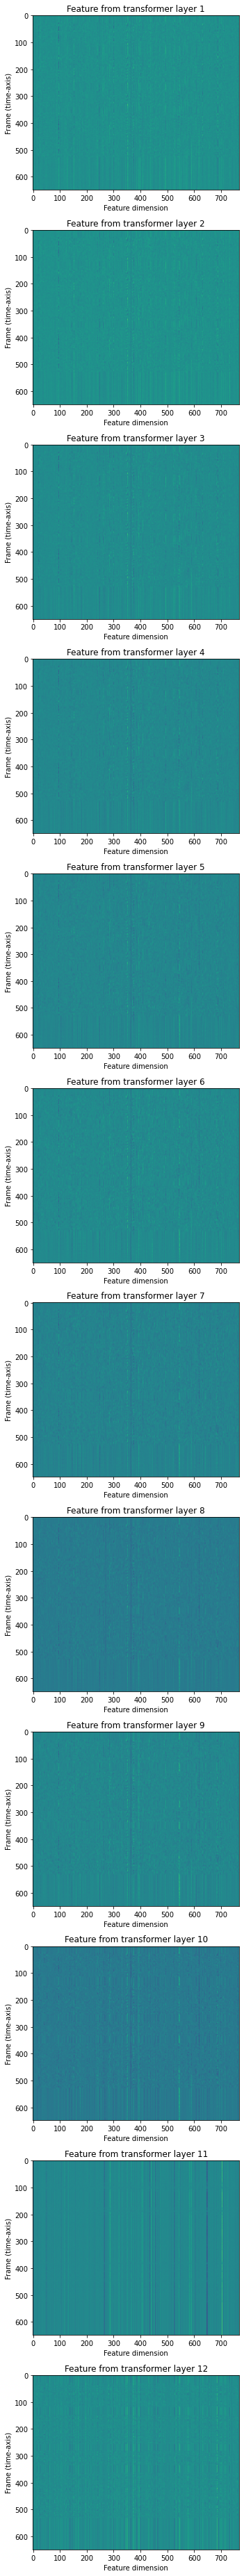

In [259]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu())
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
#plt.savefig('acoustic_features.png')
plt.show()

### Feature Classification

The next step is to classify the features into a set of categories. Wav2Vec 2.0 model provides method to perform the feature extraction and classification in one step.

In [248]:
with torch.inference_mode():
    emission, _ = model(waveform)

The output is in the form of logits. It is not in the form of probability.
Let’s visualize this.

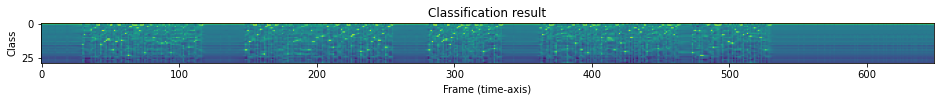

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [249]:
plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

We can see that there are strong indications to certain labels across the time line.
Note that the class 0, (-) have mostly huge negative values, this is an artifact from the original fairseq implementation where these labels are added by default but not used during the training.

### Generating transcripts

From the sequence of label probabilities, now we want to generate transcripts. The process to generate hypotheses is often called “decoding”. Decoding is more elaborate than simple classification because decoding at certain time step can be affected by surrounding observations.
There are many decoding techniques proposed, and they require external resources, such as word dictionary and language models.
In this tutorial, for the sake of simplicity, we will perform greedy decoding which does not depend on such external components, and simply pick up the best hypothesis at each time step. Therefore, the context information are not used, and only one transcript can be generated.

We start by defining a greedy decoding algorithm

In [250]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, ignore):
        super().__init__()
        self.labels = labels
        self.ignore = ignore

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.
        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i not in self.ignore]
        return ''.join([self.labels[i] for i in indices])

Now create the decoder object and decode the transcript.

In [261]:
greedy_decoder = GreedyCTCDecoder(
    labels=bundle.get_labels(),
    ignore=(0,0),
)
greedy_result = greedy_decoder(emission[0])
greedy_transcript = greedy_result.replace("|", " ").lower().strip()

Let’s check the result and listen again to the audio.

In [267]:
IPython.display.Audio(SPEECH_FILE)

In [268]:
print(greedy_transcript)

what would you like to be remumbertful you have to evolve yourself and shape your life you should write it on a page that pase may be a reary important page in the book of human history


Now we will transcript the audio using beam search decoder algorithm. For that we need to download some pre-trained models, lexicons and tokens.

In [269]:
hub_dir = torch.hub.get_dir()

token_url = "https://pytorch.s3.amazonaws.com/torchaudio/tutorial-assets/ctc-decoding/tokens-w2v2.txt"
token_file = f"{hub_dir}/token.txt"
if not os.path.isfile(token_file): 
    torch.hub.download_url_to_file(token_url, token_file)

lexicon_url = "https://pytorch.s3.amazonaws.com/torchaudio/tutorial-assets/ctc-decoding/lexicon-librispeech.txt"
lexicon_file = f"{hub_dir}/lexicon.txt"
if not os.path.isfile(lexicon_file):
    torch.hub.download_url_to_file(lexicon_url, lexicon_file)

kenlm_url = "https://pytorch.s3.amazonaws.com/torchaudio/tutorial-assets/ctc-decoding/4-gram-librispeech.bin"
kenlm_file = f"{hub_dir}/kenlm.bin"
if not os.path.isfile(kenlm_file):
    torch.hub.download_url_to_file(kenlm_url, kenlm_file)

In [270]:
from torchaudio.prototype.ctc_decoder import kenlm_lexicon_decoder
beam_search_decoder = kenlm_lexicon_decoder(
    lexicon=lexicon_file,
    tokens=token_file,
    kenlm=kenlm_file,
    nbest=1,
    beam_size=1500,
    beam_size_token=50,
    lm_weight=3.23,
    word_score=-1.39,
    unk_score=float("-inf"),
    sil_score=0,
)

In [271]:
beam_search_result = beam_search_decoder(emission)
beam_search_transcript = " ".join(beam_search_result[0][0].words).lower().strip()
print(beam_search_transcript)

what would you like to be remembered for you have to evolve yourself and shape your life you should write it on a page that it may be a very important page in the book of human history


### Conclusion

In this tutorial, we looked at how to use Pytorch and Wav2Vec 2.0 to perform acoustic feature extraction and speech recognition.
I love your feedback, please let me know what you think.